In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10458,-0.4,0.2,-1.6,0.0,0.3,0.0,0.1,-1.1,-1.3
13526,-1.2,0.8,0.5,-0.7,-0.9,-0.8,-0.9,1.2,1.4
3739,0.8,-0.8,-0.3,-0.7,-0.6,0.2,-0.6,0.2,-0.4
11116,-0.7,0.9,0.2,-1.1,-1.1,-1.1,-1.1,-1.1,-1.2
12694,-1.1,0.5,-0.1,-0.5,-0.1,0.5,-0.0,-0.8,-0.7


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [5]:
treshold = 265000
train_df_norm['median_house_value_is_high'] = (train_df['median_house_value'] > treshold).astype(float)
test_df_norm['median_house_value_is_high'] = (test_df['median_house_value'] > treshold).astype(float)
train_df_norm['median_house_value_is_high'].head(8000)

10458   0.0
13526   1.0
3739    0.0
11116   0.0
12694   0.0
         ..
14114   1.0
3245    0.0
11132   0.0
15373   0.0
350     0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-1.1404086 ,  0.01253957],
       [ 1.1955109 , -0.7457357 ],
       [ 0.16682169, -0.7420659 ],
       ...,
       [-0.02084635, -0.71362484],
       [-0.397545  ,  0.4795234 ],
       [-0.88765156, -0.8714269 ]], dtype=float32)>

In [7]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the feature layer (the list of features and how they are represented)
    # to the model.
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        


def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [8]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 0s 28us/sample - loss: 0.7744 - accuracy: 0.2678
Epoch 2/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.6890 - accuracy: 0.3535
Epoch 3/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.6164 - accuracy: 0.5258
Epoch 4/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.5569 - accuracy: 0.6736
Epoch 5/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.5100 - accuracy: 0.7491
Epoch 6/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4752 - accuracy: 0.7866
Epoch 7/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4499 - accuracy: 0.8039
Epoch 8/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4321 - accuracy: 0.8115
Epoch 9/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4197 - accuracy: 0.8138
Epoch 10/20
17

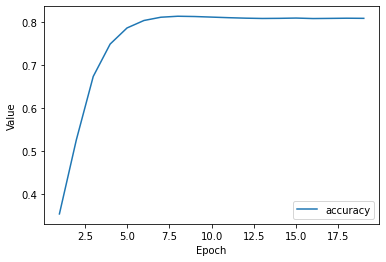

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [10]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

3000/3000 [==============================] - 0s 33us/sample - loss: 0.4068 - accuracy: 0.8013


[0.40679032206535337, 0.8013333]

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 54us/sample - loss: 1.1658 - accuracy: 0.2282 - precision: 0.1413 - recall: 0.4113
Epoch 2/20
17000/17000 [==============================] - 0s 11us/sample - loss: 1.0241 - accuracy: 0.2352 - precision: 0.1366 - recall: 0.3876
Epoch 3/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.8967 - accuracy: 0.2484 - precision: 0.1284 - recall: 0.34680s - loss: 0.9067 - accuracy: 0.2458 - precision: 0.1308 - recall: 0.354
Epoch 4/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.7883 - accuracy: 0.2759 - precision: 0.1132 - recall: 0.2778
Epoch 5/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.6969 - accuracy: 0.3531 - precision: 0.0887 - recall: 0.1714
Epoch 6/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.6233 - accuracy: 0.6102 - precision: 0.0540 - recall: 0.03390s - loss: 0.6433 - accuracy: 0.4786 - pre

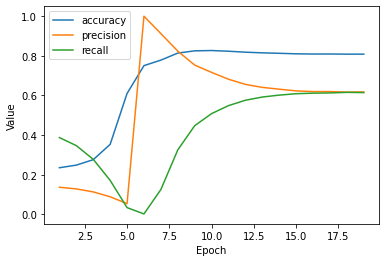

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.7292 - precision: 0.4710 - recall: 0.694 - 1s 45us/sample - loss: 0.6284 - accuracy: 0.7321 - precision: 0.4754 - recall: 0.6986
Epoch 2/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.5769 - accuracy: 0.7522 - precision: 0.5030 - recall: 0.6682
Epoch 3/20
17000/17000 [==============================] - 0s 15us/sample - loss: 0.5325 - accuracy: 0.7706 - precision: 0.5341 - recall: 0.6421
Epoch 4/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4948 - accuracy: 0.7858 - precision: 0.5662 - recall: 0.6105
Epoch 5/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4629 - accuracy: 0.7995 - precision: 0.6024 - recall: 0.5802
Epoch 6/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4376 - accuracy: 0.8116 - precision: 0.6439 - recall: 0.55000s - loss: 0.4462 - accuracy: 0.80

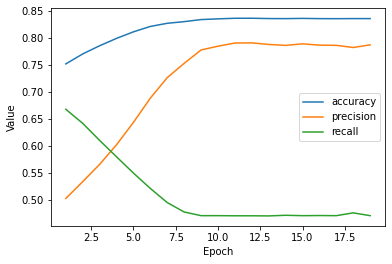

In [12]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 43us/sample - loss: 1.2492 - auc: 0.2067
Epoch 2/20
17000/17000 [==============================] - 0s 14us/sample - loss: 1.1016 - auc: 0.2076
Epoch 3/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.9690 - auc: 0.2088
Epoch 4/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.8517 - auc: 0.2104
Epoch 5/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.7522 - auc: 0.2142
Epoch 6/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.6702 - auc: 0.2212
Epoch 7/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.6043 - auc: 0.2579
Epoch 8/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.5528 - auc: 0.6588
Epoch 9/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.5125 - auc: 0.8285
Epoch 10/20
17000/17000 [==============================] - 

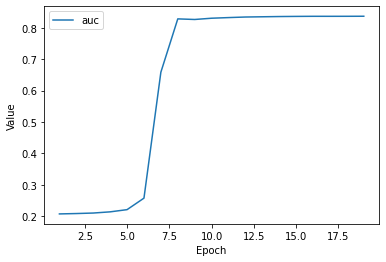

In [13]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)